In [1]:
#import os
#import json
#import datetime as dt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker

#from matplotlib.gridspec import GridSpec
#from matplotlib.dates import DateFormatter
#from matplotlib import dates
import seaborn as sns

from sklearn import linear_model
#from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
#from sklearn import neural_network
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.base import BaseEstimator
#from sklearn.base import ClassifierMixin
#from sklearn.base import clone
#from sklearn.pipeline import _name_estimators
#from sklearn import datasets
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import cross_val_score
#from itertools import product
#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [91]:
# save the processed data for easier loading/processing later
t2mfile_csv     = '/Users/ryaneagan/MAST638/Project/MAST638_Data/CSV/smith_t2m_2003_2023.csv'
sstfile_csv     = '/Users/ryaneagan/MAST638/Project/MAST638_Data/CSV/smith_sst_2003_2023.csv'
dlwfile_csv     = '/Users/ryaneagan/MAST638/Project/MAST638_Data/CSV/smith_dlw_2003_2023.csv'
windfile_csv    = '/Users/ryaneagan/MAST638/Project/MAST638_Data/CSV/smith_wnd_2003_2023.csv'
cloudfile_csv   = '/Users/ryaneagan/MAST638/Project/MAST638_Data/CSV/smith_cld_2003_2023.csv'
rhfile_csv      = '/Users/ryaneagan/MAST638/Project/MAST638_Data/CSV/smith_rhp_2003_2023.csv'
seaicefile_csv  = '/Users/ryaneagan/MAST638/Project/MAST638_Data/CSV/smith_seaice_2003_2023.csv'

In [92]:
def loadcsv(filename):
    df = pd.read_csv(filename)
    df['dateandtime'] = pd.to_datetime(df['time'])
    df.set_index(['dateandtime'],inplace=True)
    df.drop(columns=['time'],inplace=True)
    return df

In [94]:
# load the files from CSV

t2m_weekly = loadcsv(t2mfile_csv)
sst_weekly = loadcsv(sstfile_csv)
dlw_weekly = loadcsv(dlwfile_csv)
wind_weekly = loadcsv(windfile_csv)
cloud_weekly = loadcsv(cloudfile_csv)
rh_weekly = loadcsv(rhfile_csv)
seaice_weekly = loadcsv(seaicefile_csv)

In [95]:
# add weeks column for sorting and selecting later

winter_weeks = [45,46,47,48,49,50,51,52,1,2,3,4,5,6,7,8]

t2m_weekly['Week']      = t2m_weekly.index.isocalendar().week
sst_weekly['Week']      = sst_weekly.index.isocalendar().week
dlw_weekly['Week']      = dlw_weekly.index.isocalendar().week
wind_weekly['Week']     = wind_weekly.index.isocalendar().week
cloud_weekly['Week']    = cloud_weekly.index.isocalendar().week
rh_weekly['Week']       = rh_weekly.index.isocalendar().week
seaice_weekly['Week']   = seaice_weekly.index.isocalendar().week


In [96]:
t2m_winter      = t2m_weekly[t2m_weekly['Week'].isin(winter_weeks)]
sst_winter      = sst_weekly[sst_weekly['Week'].isin(winter_weeks)]
dlw_winter      = dlw_weekly[dlw_weekly['Week'].isin(winter_weeks)]
wind_winter     = wind_weekly[wind_weekly['Week'].isin(winter_weeks)]
cloud_winter    = cloud_weekly[cloud_weekly['Week'].isin(winter_weeks)]
rh_winter       = rh_weekly[rh_weekly['Week'].isin(winter_weeks)]
seaice_winter   = seaice_weekly[seaice_weekly['Week'].isin(winter_weeks)]

t2m_weekly.drop(columns=['Week'],inplace=True)
sst_weekly.drop(columns=['Week'],inplace=True)
dlw_weekly.drop(columns=['Week'],inplace=True)
wind_weekly.drop(columns=['Week'],inplace=True)
cloud_weekly.drop(columns=['Week'],inplace=True)
rh_weekly.drop(columns=['Week'],inplace=True)
seaice_weekly.drop(columns=['Week'],inplace=True)

In [97]:
t2m_winter.drop(columns=['Week'],inplace=True)
sst_winter.drop(columns=['Week'],inplace=True)
dlw_winter.drop(columns=['Week'],inplace=True)
wind_winter.drop(columns=['Week'],inplace=True)
cloud_winter.drop(columns=['Week'],inplace=True)
rh_winter.drop(columns=['Week'],inplace=True)
seaice_winter.drop(columns=['Week'],inplace=True)

In [98]:
# drop outlier function

def drop_outliers(df,varName,qmin,qmax):
    s_qmin_max = df[varName].quantile([qmin,qmax])
    newdf = df[(df[varName] > s_qmin_max[qmin]) & (df[varName] < s_qmin_max[qmax])]
    return newdf

In [99]:
def combineDFS(dfs):
    pdflist = dfs
    from functools import reduce
    df_merged = reduce(lambda  left,right: 
                       pd.merge(left,right,left_index=True,right_index=True,
                                how='outer'), 
                       pdflist)
    
    return df_merged

In [100]:
t2m_winter = drop_outliers(t2m_winter,'t2m',0.05,0.95)
seaice_winter = drop_outliers(seaice_winter,'tc_mid',0.05,0.95)

In [101]:
# combine all of the individual dataframes into one dataframe for feature engineering

dfs = [
    t2m_weekly, 
    #sst_weekly,  
    dlw_weekly,  
    wind_weekly,  
    cloud_weekly, 
    rh_weekly,
    seaice_weekly
]

df = combineDFS(dfs)

winter_dfs = [
    t2m_winter,
    #sst_winter,   
    dlw_winter,   
    wind_winter,   
    cloud_winter,  
    rh_winter, 
    seaice_winter 
]

wdf = combineDFS(winter_dfs)

In [102]:
df = df.reset_index(drop=True)
wdf = wdf.reset_index(drop=True)

In [ ]:
#drop the columns we don't want
#df.drop(columns=['u10','v10','z'],inplace=True)
#wdf.drop(columns=['u10','v10','z'],inplace=True)

In [103]:
# drop rows with NAN

df = df.dropna(axis=0)
wdf = wdf.dropna(axis=0)

In [104]:

# add lagged ice cocentration columns
df['tc_mid_1w'] = df['tc_mid'].shift(1)
df['tc_mid_2w'] = df['tc_mid'].shift(2)
df['tc_mid_4w'] = df['tc_mid'].shift(4)

#drop the NAN rows created by the shift
df = df.dropna(axis=0)

In [105]:
# add lagged ice cocentration columns
wdf['tc_mid_1w'] = wdf['tc_mid'].shift(1)
wdf['tc_mid_2w'] = wdf['tc_mid'].shift(2)
wdf['tc_mid_4w'] = wdf['tc_mid'].shift(4)

#drop the NAN rows created by the shift
wdf = wdf.dropna(axis=0)

In [16]:
wdf.columns

Index(['t2m', 'ssrd', 'u10', 'v10', 'magnitude', 'direction', 'lcc', 'tcc',
       'z', 'r', 'tc_mid', 'tc_mid_1w', 'tc_mid_2w', 'tc_mid_4w'],
      dtype='object')

[Text(0.5, 1.0, 'Z-Score Feature Box Plot')]

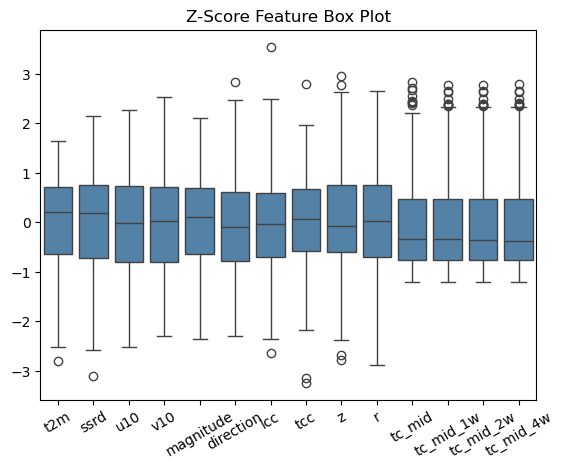

In [106]:
from scipy.stats import zscore
zwdf = wdf.apply(zscore)
bxax = sns.boxplot(data=zwdf,color='steelblue')
bxax.set_xticklabels(bxax.get_xticklabels(),rotation=30)
bxax.set(title='Z-Score Feature Box Plot')

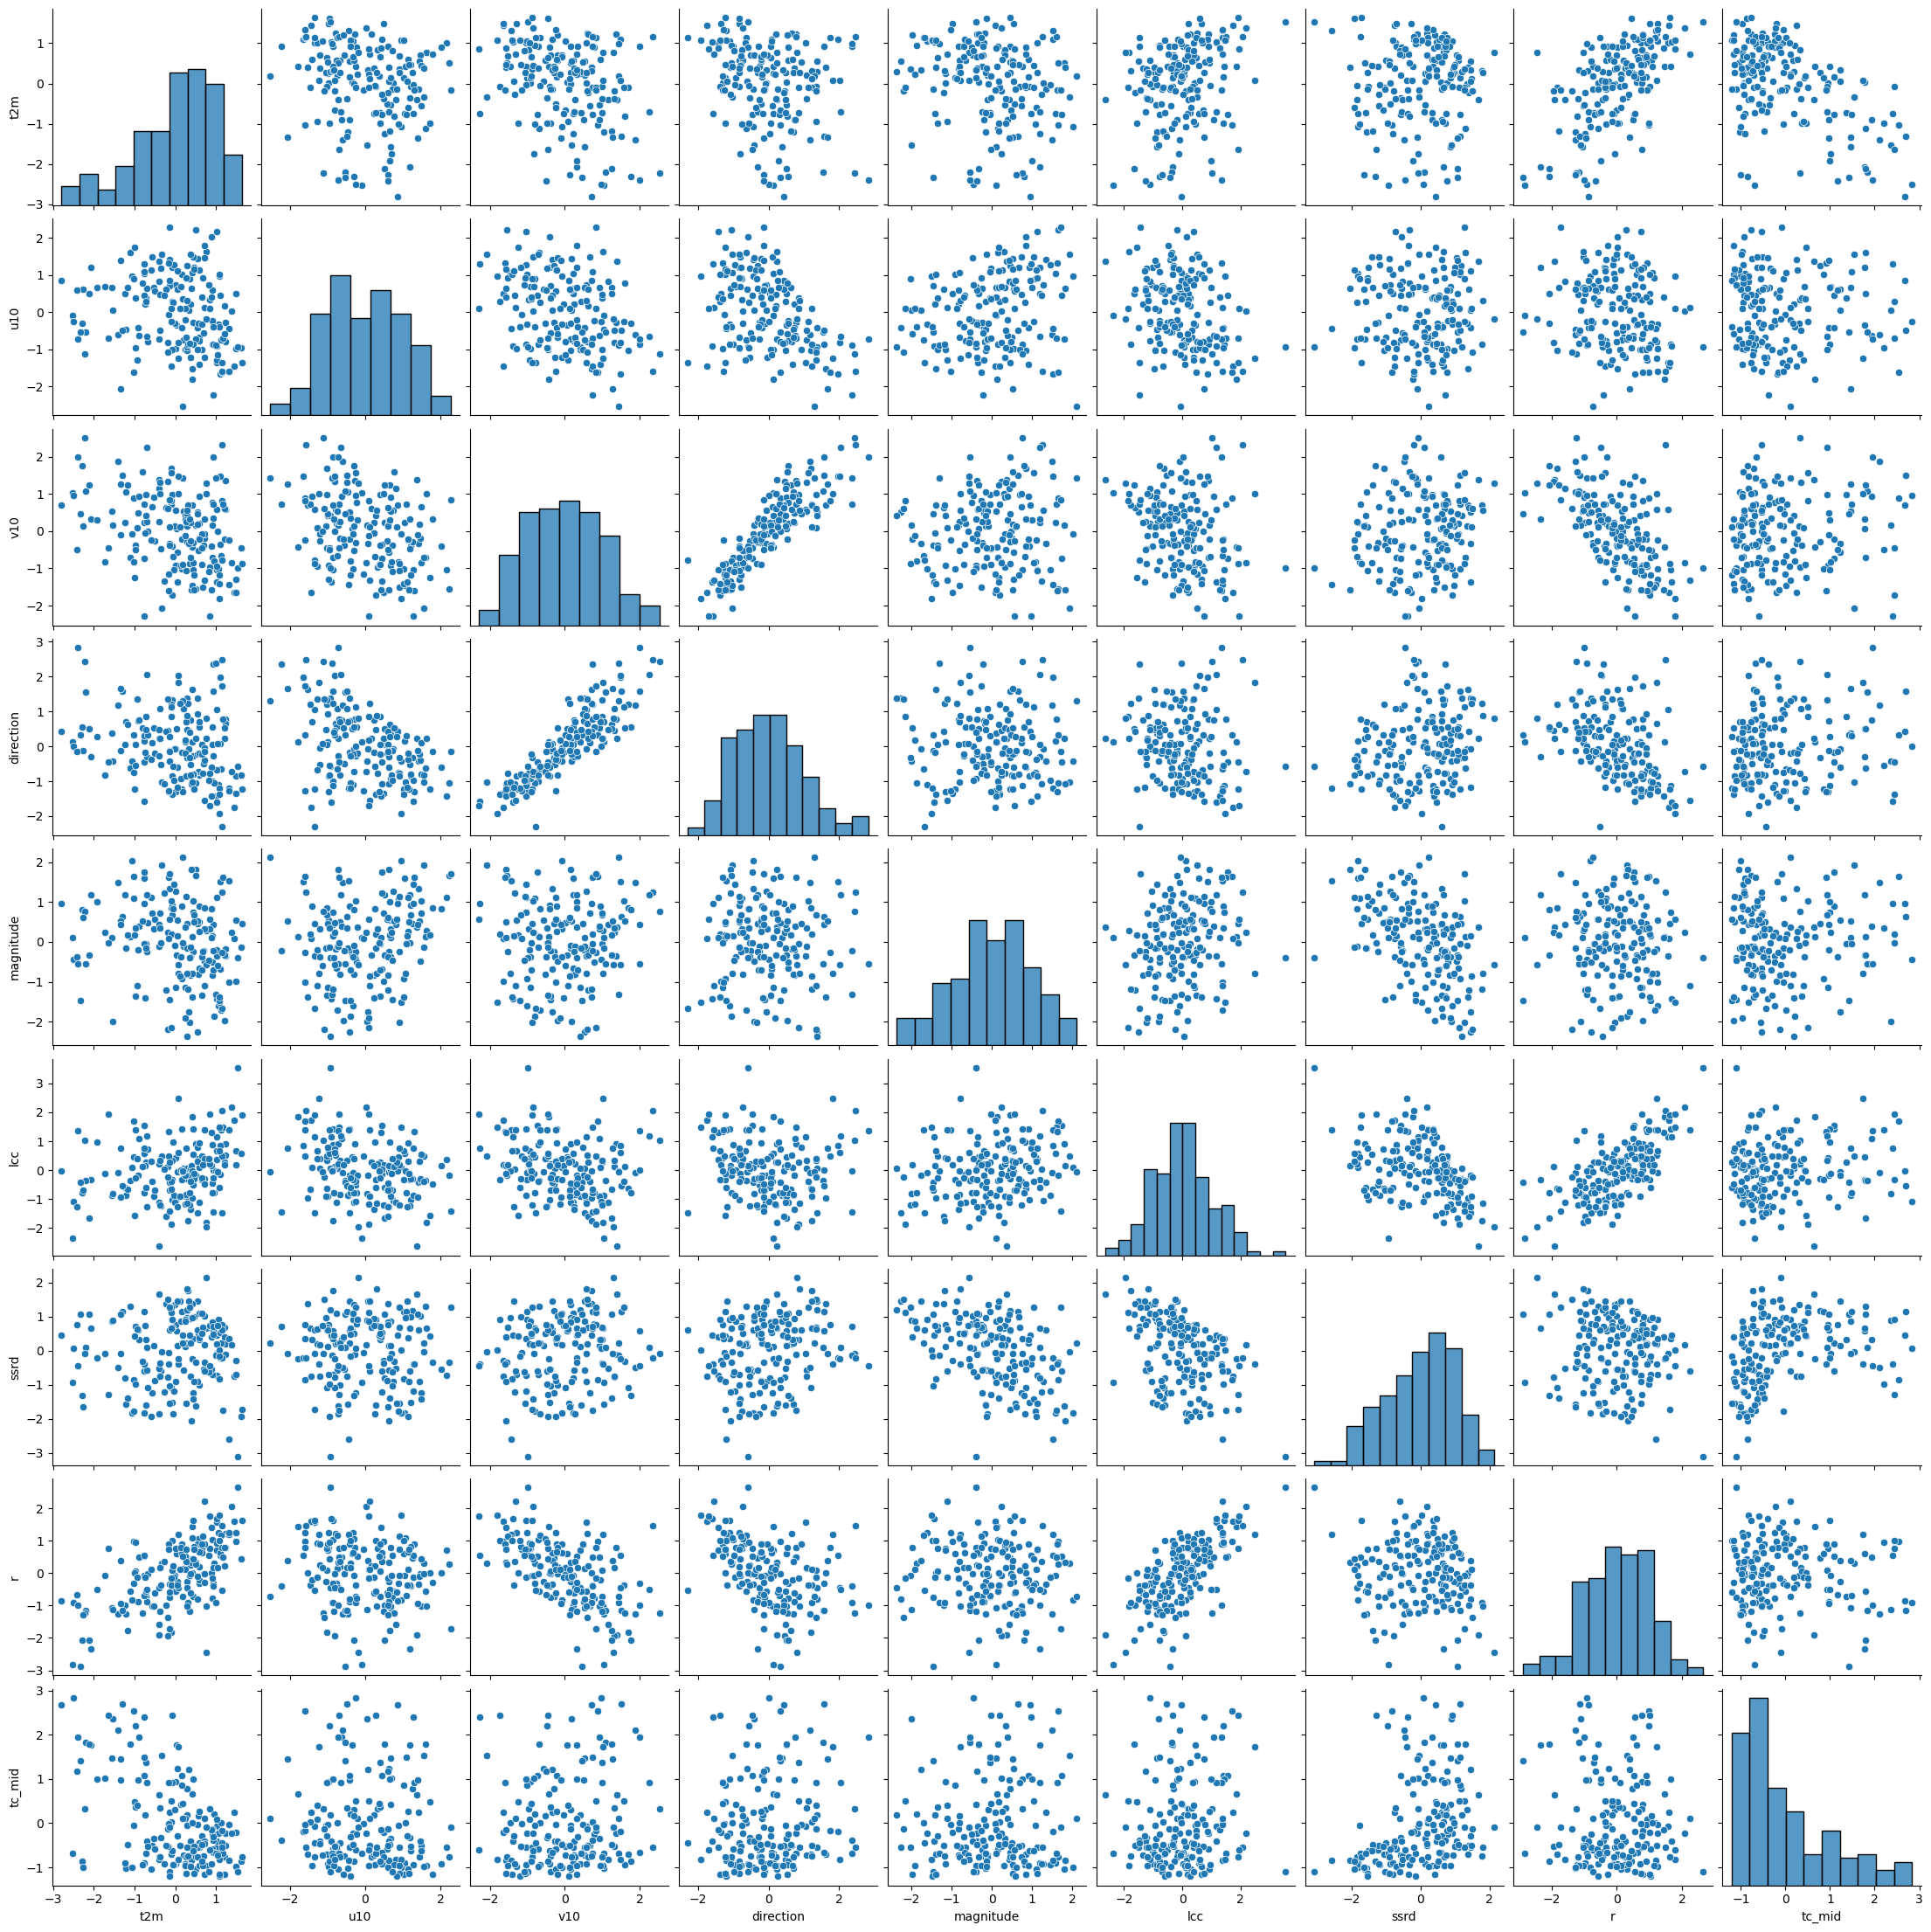

In [107]:
#sns.pairplot(zwdf[['t2m','sst','direction','magnitude','lcc','ssrd','r','tc_mid']])
sns.pairplot(zwdf[['t2m','u10','v10','direction','magnitude','lcc','ssrd','r','tc_mid']])

<Axes: >

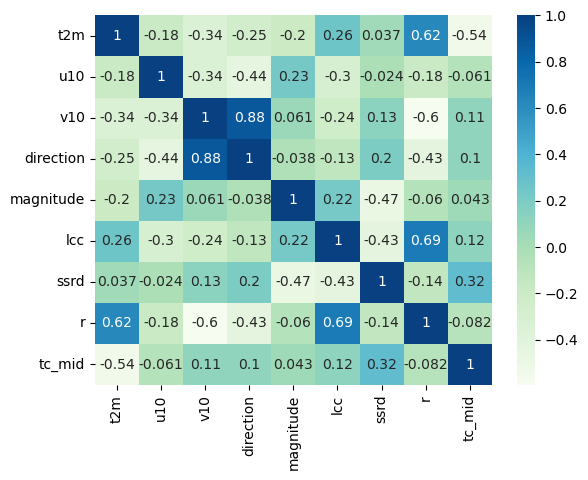

In [108]:
#corr = zwdf[['t2m','sst','direction','magnitude','lcc','ssrd','r','tc_mid']].corr()
#corr = zwdf[['t2m','u10','v10','direction','magnitude','lcc','ssrd','r','tc_mid']].corr()
corr = zwdf[['t2m','u10','v10','direction','magnitude','lcc','ssrd','r','tc_mid']].corr()
sns.heatmap(corr, cmap = "GnBu", annot = True)

In [110]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,t2m,u10,v10,direction,magnitude,lcc,ssrd,r,tc_mid
t2m,nan,nan,nan,nan,nan,nan,nan,nan,nan
u10,-0.18,nan,nan,nan,nan,nan,nan,nan,nan
v10,-0.34,-0.34,nan,nan,nan,nan,nan,nan,nan
direction,-0.25,-0.44,0.88,nan,nan,nan,nan,nan,nan
magnitude,-0.20,0.23,0.06,-0.04,nan,nan,nan,nan,nan
lcc,0.26,-0.30,-0.24,-0.13,0.22,nan,nan,nan,nan
ssrd,0.04,-0.02,0.13,0.20,-0.47,-0.43,nan,nan,nan
r,0.62,-0.18,-0.60,-0.43,-0.06,0.69,-0.14,nan,nan
tc_mid,-0.54,-0.06,0.11,0.10,0.04,0.12,0.32,-0.08,nan


In [67]:
def regression_plot(y_predicted, y_test, title):
    fig, ax = plt.subplots()
    ax.scatter(y_predicted, y_test, edgecolors=(0, 0, 1))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)
    fig.show()

In [68]:
def add_stats(y_predicted, y_test):
    # model evaluation for testing set

    mae = metrics.mean_absolute_error(y_test, y_predicted)
    mse = metrics.mean_squared_error(y_test, y_predicted)
    r2 = metrics.r2_score(y_test, y_predicted)
    evar = metrics.explained_variance_score(y_test, y_predicted)

    print("The model performance for testing set")
    print("--------------------------------------")
    print('MAE is {}'.format(mae))
    print('MSE is {}'.format(mse))
    print('R2 score is {}'.format(r2))
    print('Explained Variance Score is {}'.format(evar))
    print('---------------------------------------"\n')
    
    return [mae,mse,r2,evar]

In [69]:
model_stats = {'columns':['MAE','MSE','R2','ExpVarScore']}

In [70]:
alpha_range = [1.0,0.1,0.001,0.0001,0.00001]

The model performance for testing set
--------------------------------------
MAE is 6.7379262406244465
MSE is 74.1059045719631
R2 score is 0.38090856913537174
Explained Variance Score is 0.38601757253156654
---------------------------------------"



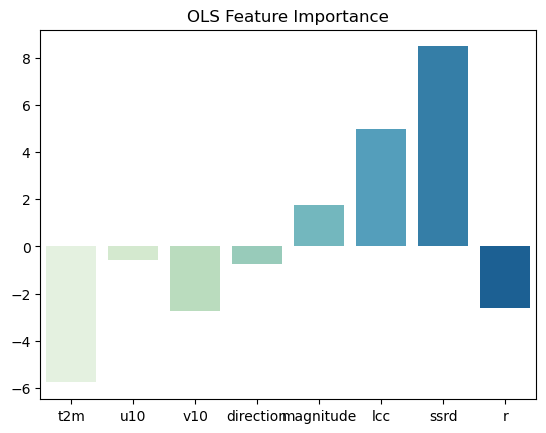

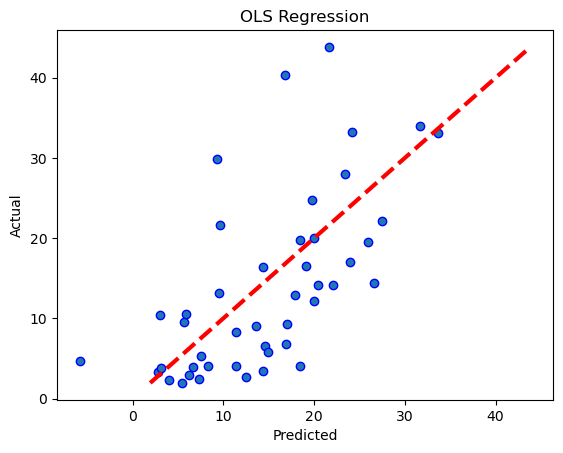

In [71]:
#predictor_cols = ['t2m','sst','direction','magnitude','lcc','ssrd','r']
predictor_cols = ['t2m','u10','v10','direction','magnitude','lcc','ssrd','r']
predictand_col = ['tc_mid']

X_train, X_test, y_train, y_test = train_test_split(wdf[predictor_cols], wdf[predictand_col],test_size=0.3,random_state=5,shuffle=False)

# trial OLS


pipe_linear = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('ols',linear_model.LinearRegression()),

    ]
)
pipe_linear.fit(X_train, y_train)
y_pred = pipe_linear.predict(X_test)

model = pipe_linear.named_steps['ols']
coef = model.coef_
intercept = model.intercept_

sns.barplot(x = predictor_cols, y=coef[0], palette='GnBu').set(title='OLS Feature Importance')

regression_plot(y_pred,y_test,'OLS Regression')

ols_stats = add_stats(y_pred,y_test)
model_stats['ols'] = ols_stats


The model performance for testing set
--------------------------------------
MAE is 7.163653907225282
MSE is 82.02938558700191
R2 score is 0.31471466424530214
Explained Variance Score is 0.3240225116017307
---------------------------------------"



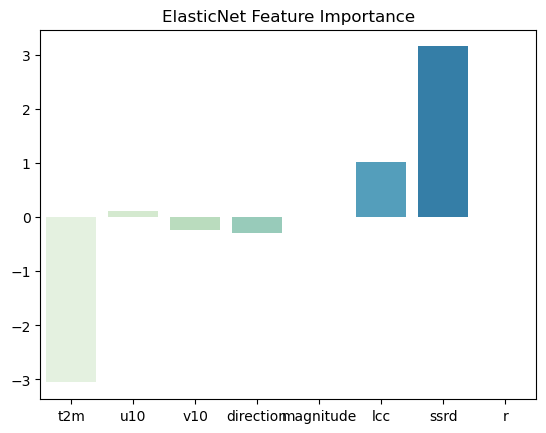

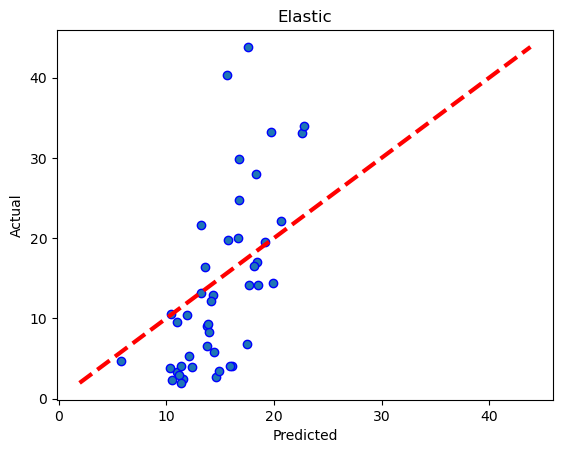

In [72]:
pipe_elastic = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('elastic',linear_model.ElasticNet(alpha=1.0, l1_ratio=0.50))

    ]
)

pipe_elastic.fit(X_train, y_train)
y_elastic_pred = pipe_elastic.predict(X_test)

elastic_model = pipe_elastic.named_steps['elastic']

elastic_coef = elastic_model.coef_
elastic_intercept = elastic_model.intercept_

sns.barplot(x = predictor_cols, y=elastic_coef, palette='GnBu').set(title='ElasticNet Feature Importance')

regression_plot(y_elastic_pred,y_test,'Elastic')
elastic_stats = add_stats(y_elastic_pred,y_test)
model_stats['elastic'] = elastic_stats

The model performance for testing set
--------------------------------------
MAE is 6.456344877551523
MSE is 74.19766009526332
R2 score is 0.3801420302402895
Explained Variance Score is 0.39031780798854065
---------------------------------------"



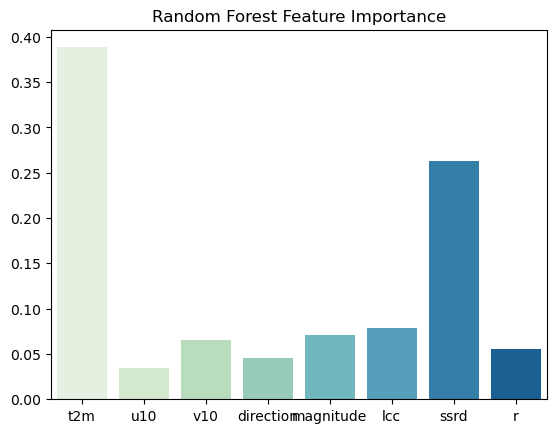

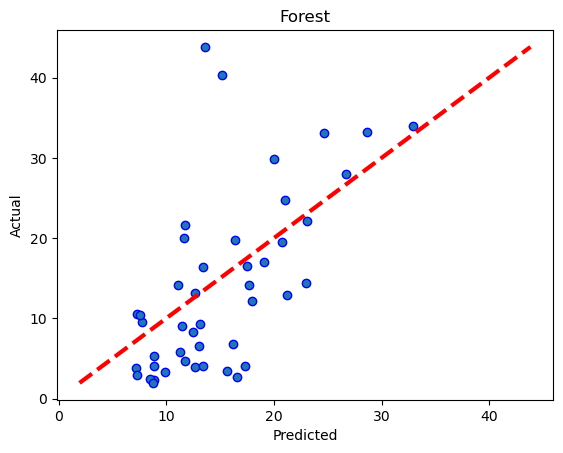

In [73]:
tree_model = ensemble.RandomForestRegressor()

tree_model.fit(X_train, y_train)
y_tree_pred = tree_model.predict(X_test)

forest_importances = tree_model.feature_importances_

sns.barplot(x = predictor_cols, y=forest_importances, palette='GnBu').set(title='Random Forest Feature Importance')

regression_plot(y_tree_pred,y_test,'Forest')

forest_stats = add_stats(y_tree_pred,y_test)
model_stats['forest'] = forest_stats

The model performance for testing set
--------------------------------------
MAE is 6.6382040135096
MSE is 71.92602244147099
R2 score is 0.3991196193219606
Explained Variance Score is 0.4043004211076694
---------------------------------------"



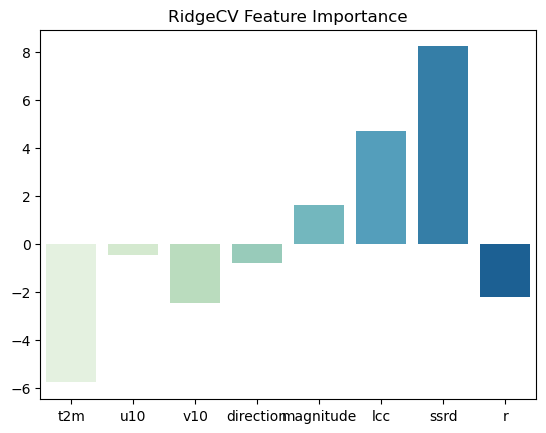

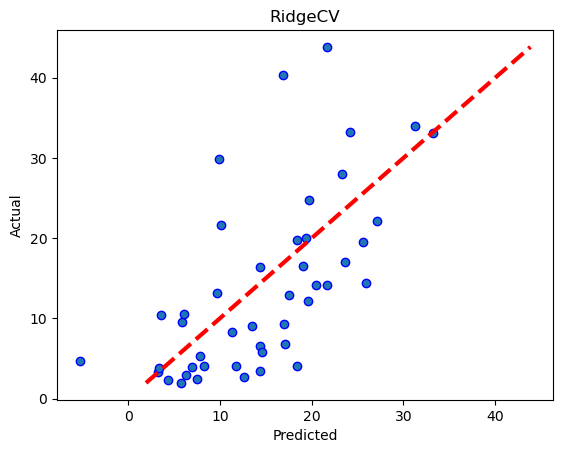

In [74]:
pipe_ridgecv = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('ridgecv',linear_model.RidgeCV(alphas=alpha_range,cv=5))

    ]
)

pipe_ridgecv.fit(X_train,y_train)

y_ridgecv_pred = pipe_ridgecv.predict(X_test)

ridgecv_model = pipe_ridgecv.named_steps['ridgecv']

ridgecv_alpha = ridgecv_model.alpha_
ridgecv_coef = ridgecv_model.coef_

sns.barplot(x = predictor_cols, y=ridgecv_coef[0], palette='GnBu').set(title='RidgeCV Feature Importance')

regression_plot(y_ridgecv_pred,y_test,'RidgeCV')
ridgecv_stats = add_stats(y_ridgecv_pred,y_test)
model_stats['ridgecv'] = ridgecv_stats

The model performance for testing set
--------------------------------------
MAE is 6.467121181448124
MSE is 67.23607238878897
R2 score is 0.43830013949196944
Explained Variance Score is 0.444396091563641
---------------------------------------"



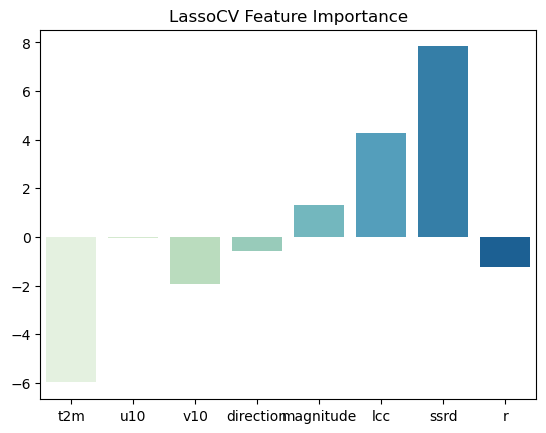

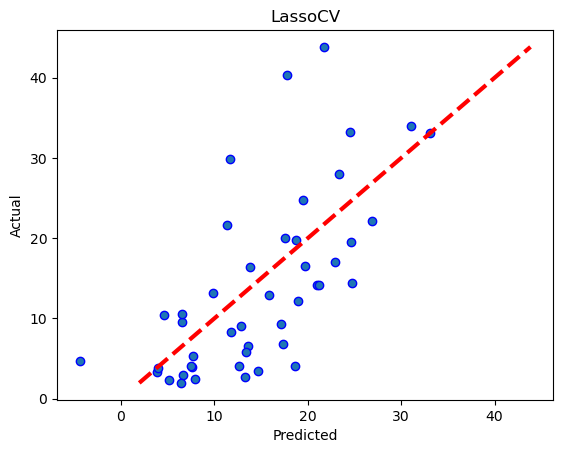

In [75]:
pipe_lassocv = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('lassocv',linear_model.LassoCV(alphas=alpha_range,cv=5))
    ]
)

pipe_lassocv.fit(X_train,y_train)

lassocv_model = pipe_lassocv.named_steps['lassocv']

y_lassocv_pred = pipe_lassocv.predict(X_test)

lassocv_coef = lassocv_model.coef_
lassocv_alpha = lassocv_model.alpha_

sns.barplot(x = predictor_cols, y=lassocv_coef, palette='GnBu').set(title='LassoCV Feature Importance')
regression_plot(y_lassocv_pred,y_test,'LassoCV')

lassocv_stats = add_stats(y_lassocv_pred,y_test)
model_stats['lassocv'] = lassocv_stats

The model performance for testing set
--------------------------------------
MAE is 6.4811985035478
MSE is 66.15762858992663
R2 score is 0.44730961476119613
Explained Variance Score is 0.45335617507616943
---------------------------------------"



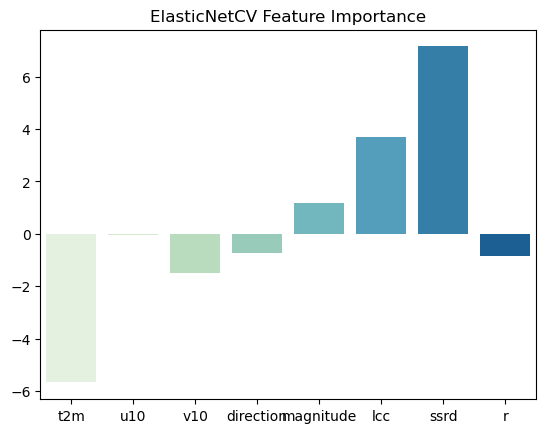

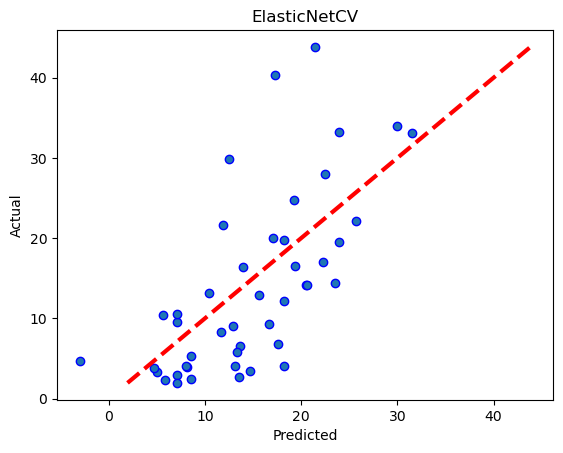

In [76]:
pipe_elasticcv = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('elasticcv',linear_model.ElasticNetCV(alphas=alpha_range))
    ]
)

pipe_elasticcv.fit(X_train,y_train)

elasticcv_model = pipe_elasticcv.named_steps['elasticcv']

y_elasticcv_pred = pipe_elasticcv.predict(X_test)

elasticcv_alpha = elasticcv_model.alpha_
elasticcv_coef = elasticcv_model.coef_

sns.barplot(x = predictor_cols, y=elasticcv_coef, palette='GnBu').set(title='ElasticNetCV Feature Importance')
regression_plot(y_elasticcv_pred,y_test,'ElasticNetCV')

elasticcv_stats = add_stats(y_elasticcv_pred,y_test)
model_stats['elasticcv'] = elasticcv_stats

The model performance for testing set
--------------------------------------
MAE is 6.546426782357078
MSE is 68.797409360495
R2 score is 0.42525650490632494
Explained Variance Score is 0.43066222886777294
---------------------------------------"



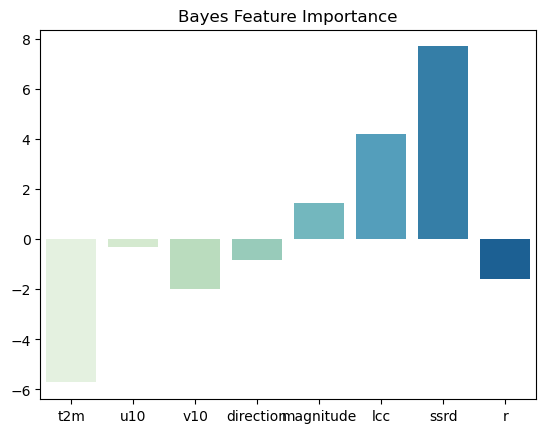

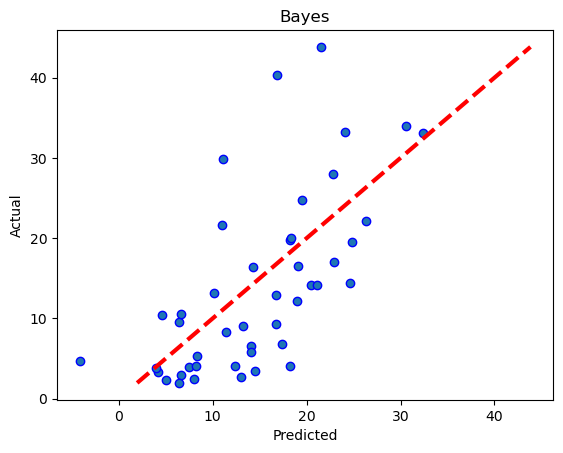

In [77]:
pipe_bayes = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('bayes',linear_model.BayesianRidge())

    ]
)

pipe_bayes.fit(X_train,y_train)

y_bayes_pred = pipe_bayes.predict(X_test)

bayes_model = pipe_bayes.named_steps['bayes']

bayes_coef = bayes_model.coef_

sns.barplot(x = predictor_cols, y=bayes_coef, palette='GnBu').set(title='Bayes Feature Importance')

regression_plot(y_bayes_pred,y_test,'Bayes')

bayes_stats = add_stats(y_bayes_pred,y_test)
model_stats['bayes'] = bayes_stats

The model performance for testing set
--------------------------------------
MAE is 6.417527081123161
MSE is 66.54508034071402
R2 score is 0.4440727868704707
Explained Variance Score is 0.4488760110484262
---------------------------------------"



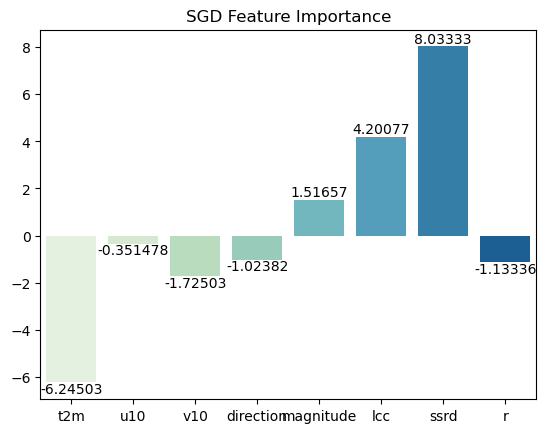

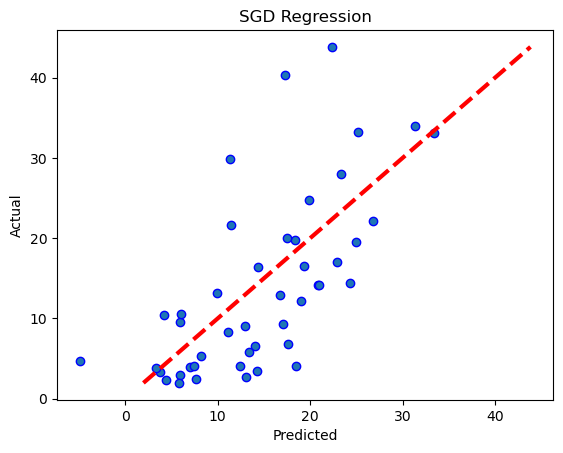

In [78]:
pipe_sgd = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('sgd',linear_model.SGDRegressor())

    ]
)

pipe_sgd.fit(X_train,y_train)

y_sgd_pred = pipe_sgd.predict(X_test)

sgd_model = pipe_sgd.named_steps['sgd']

sgd_coef = sgd_model.coef_

ax = sns.barplot(x = predictor_cols, y=sgd_coef, palette='GnBu')
ax.set(title='SGD Feature Importance')
for i in ax.containers:
    ax.bar_label(i,)

regression_plot(y_sgd_pred,y_test,'SGD Regression')

sgd_stats = add_stats(y_sgd_pred,y_test)
model_stats['sgd'] = sgd_stats

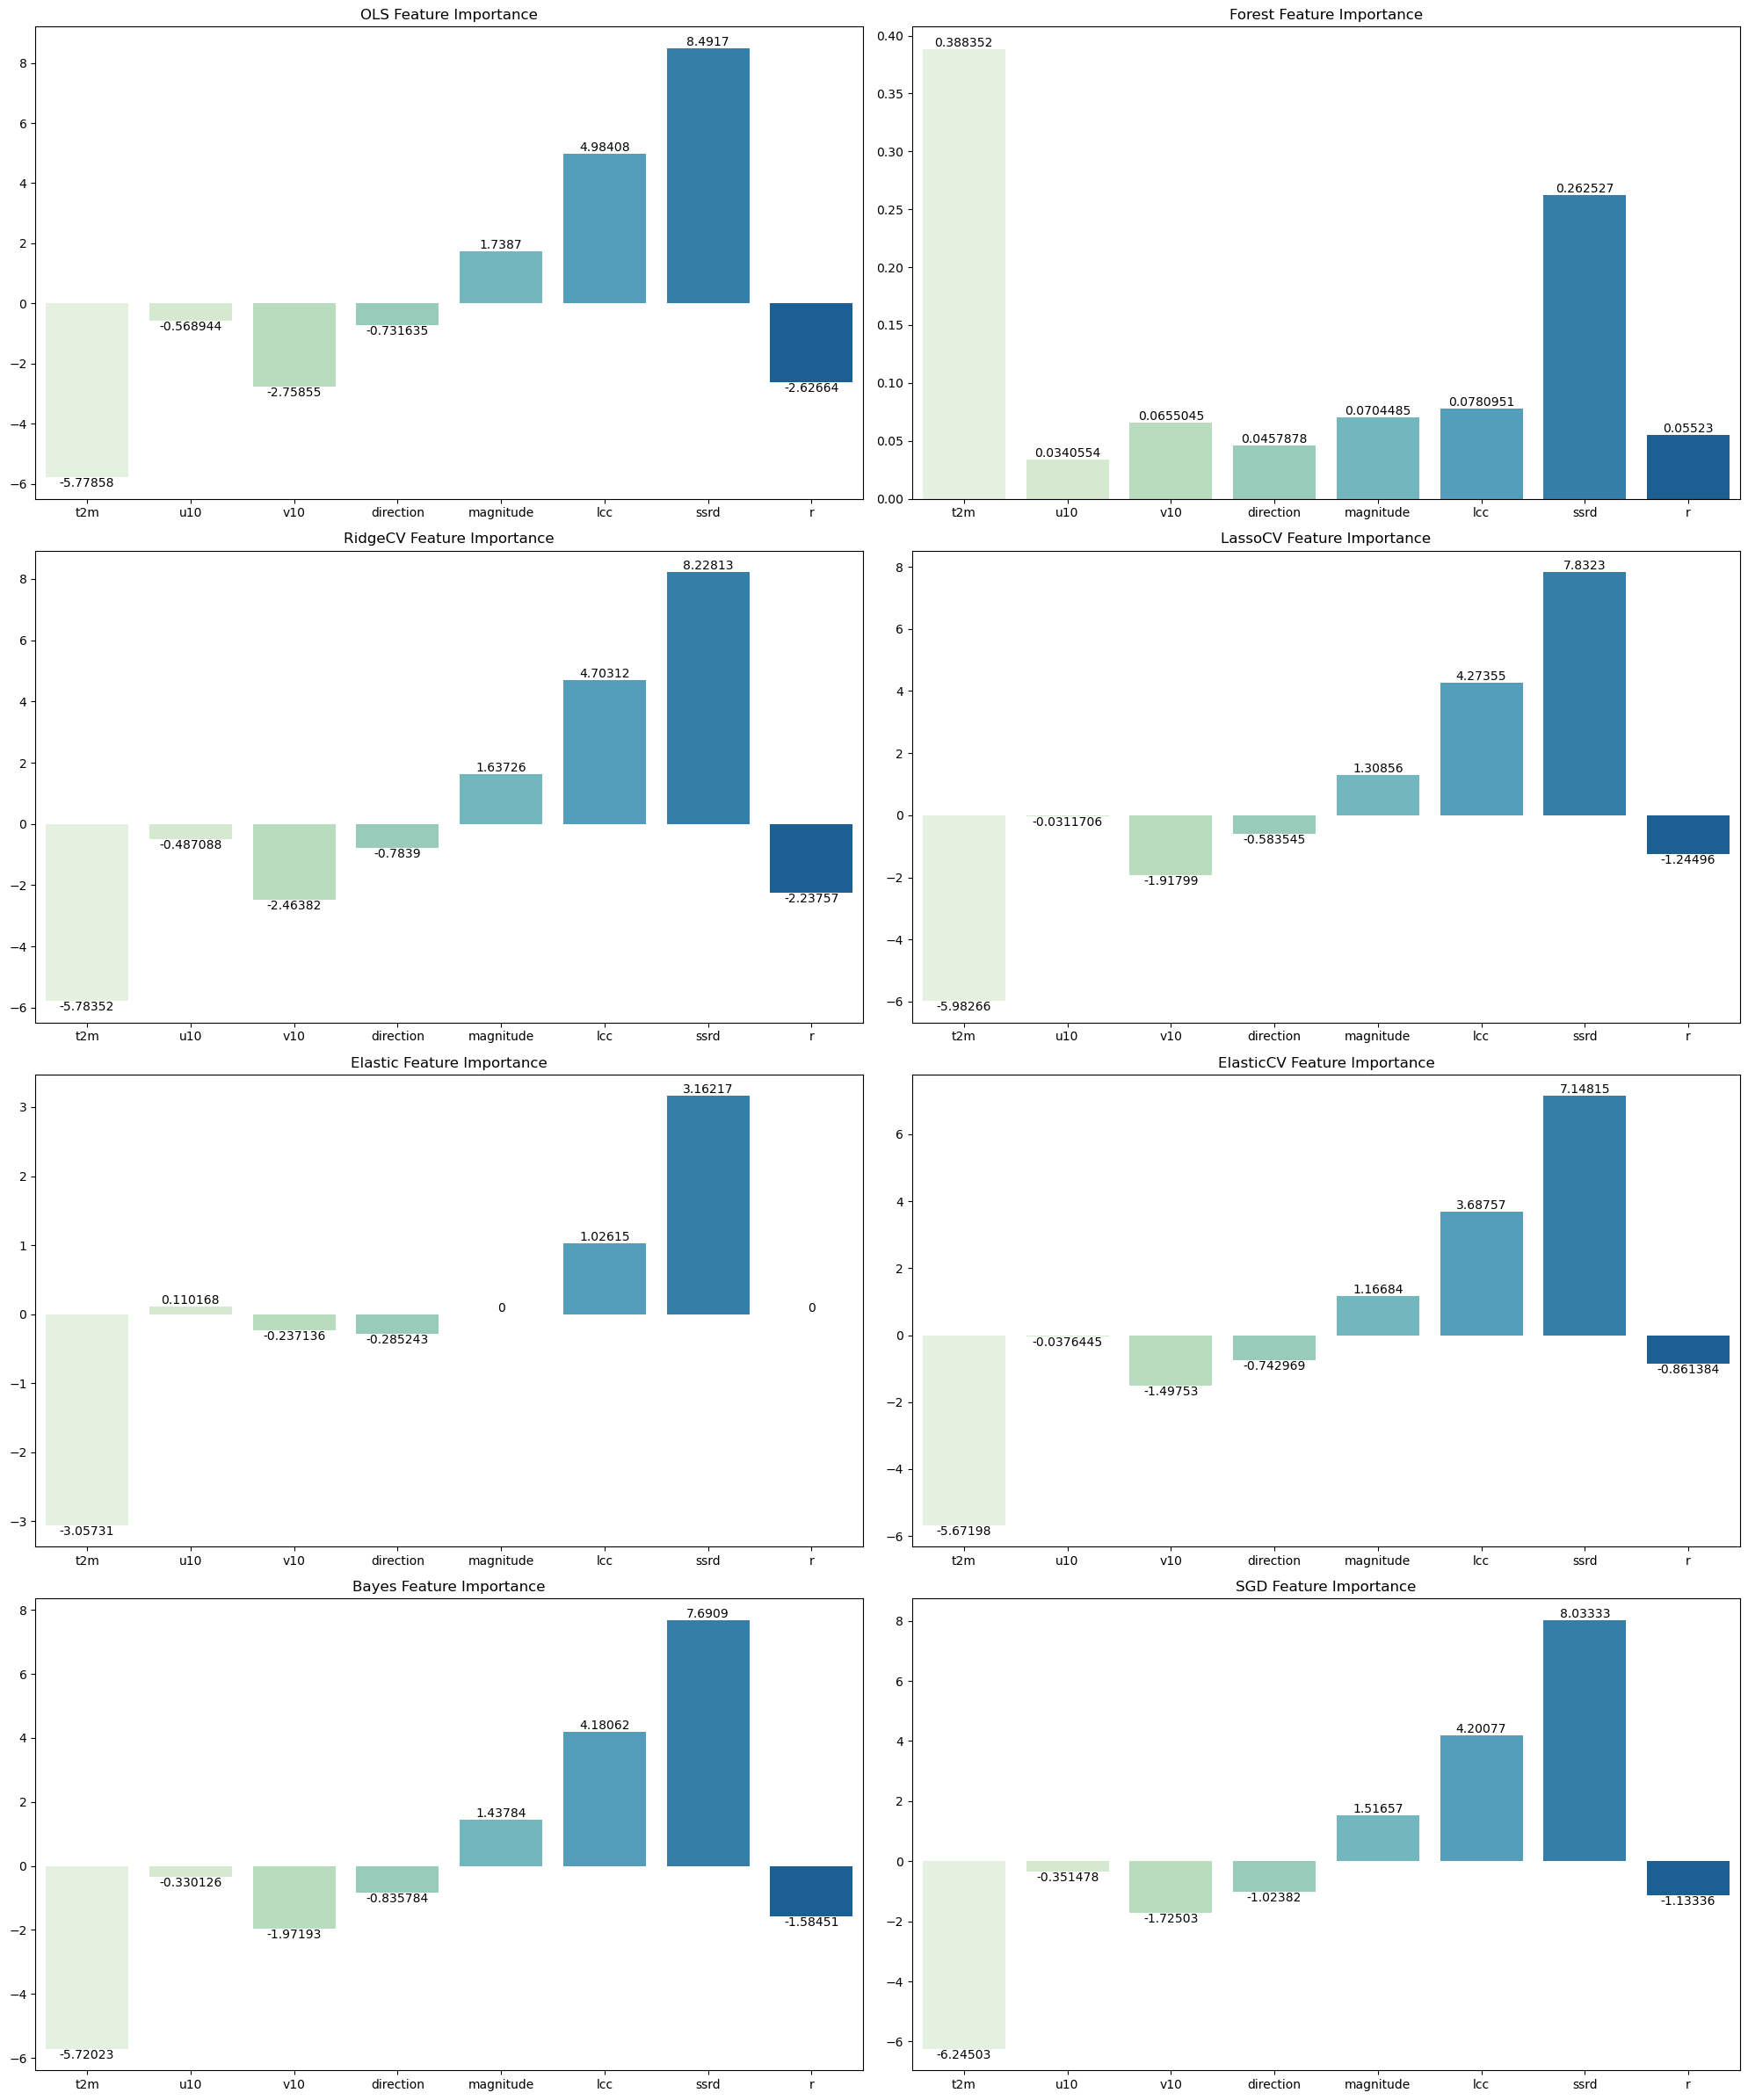

In [79]:
barfig, baxes = plt.subplots(4,2,figsize=(20,24))

all_ax = baxes.ravel()

sns.barplot(x = predictor_cols, y=coef[0], palette='GnBu',ax=all_ax[0])
all_ax[0].set(title='OLS Feature Importance')

sns.barplot(x = predictor_cols, y=forest_importances, palette='GnBu',ax=all_ax[1])
all_ax[1].set(title='Forest Feature Importance')

sns.barplot(x = predictor_cols, y=ridgecv_coef[0], palette='GnBu',ax=all_ax[2])
all_ax[2].set(title='RidgeCV Feature Importance')

sns.barplot(x = predictor_cols, y=lassocv_coef, palette='GnBu',ax=all_ax[3])
all_ax[3].set(title='LassoCV Feature Importance')

sns.barplot(x = predictor_cols, y=elastic_coef, palette='GnBu',ax=all_ax[4])
all_ax[4].set(title='Elastic Feature Importance')

sns.barplot(x = predictor_cols, y=elasticcv_coef, palette='GnBu',ax=all_ax[5])
all_ax[5].set(title='ElasticCV Feature Importance')

sns.barplot(x = predictor_cols, y=bayes_coef, palette='GnBu',ax=all_ax[6])
all_ax[6].set(title='Bayes Feature Importance')

sns.barplot(x = predictor_cols, y=sgd_coef, palette='GnBu',ax=all_ax[7])
all_ax[7].set(title='SGD Feature Importance')

for j in range(len(all_ax)):
    for i in all_ax[j].containers:
        all_ax[j].bar_label(i,)

barfig.tight_layout()

In [ ]:
print(model_stats)

In [80]:
ms = pd.DataFrame.from_dict(model_stats,orient='index')

In [81]:
ms.rename(columns={0:'MAE',1:'MSE',2:'R2',3:'EVS'},inplace=True)

ms['MAE'] = pd.to_numeric(ms['MAE'], errors='coerce')
ms['MSE'] = pd.to_numeric(ms['MSE'], errors='coerce')
ms['R2'] = pd.to_numeric(ms['R2'], errors='coerce')
ms['EVS'] = pd.to_numeric(ms['EVS'], errors='coerce')

ms.reset_index(drop=True)
ms.drop(index=ms.index[0], axis=0, inplace=True)

In [82]:
ms.describe()

,MAE,MSE,R2,EVS
count,8.000000,8.000000,8.000000,8.000000
mean,6.613550,71.374395,0.403728,0.410244
std,0.246488,5.392701,0.045051,0.043733
min,6.417527,66.157629,0.314715,0.324023
25%,6.464427,67.063324,0.380717,0.389243
50%,6.513813,70.361716,0.412188,0.417481
75%,6.663135,74.128843,0.439743,0.445516
max,7.163654,82.029386,0.447310,0.453356


In [83]:
model_stats_csv  = '/Users/ryaneagan/MAST638/Project/MAST638_Data/CSV/ddu_model_stats.csv'
ms.to_csv(model_stats_csv)

In [ ]:
ms

In [84]:
print(X_train.count())
print(X_test.count())


t2m          102
u10          102
v10          102
direction    102
magnitude    102
lcc          102
ssrd         102
r            102
dtype: int64
t2m          45
u10          45
v10          45
direction    45
magnitude    45
lcc          45
ssrd         45
r            45
dtype: int64


In [85]:
lassocv_alpha

0.1

In [ ]:
#tree.plot_tree(tree_model, max_depth=6)

In [86]:
from sklearn.inspection import permutation_importance


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

Reference:

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f

https://medium.com/@hertan06/which-features-to-use-in-your-model-350630a1e31c



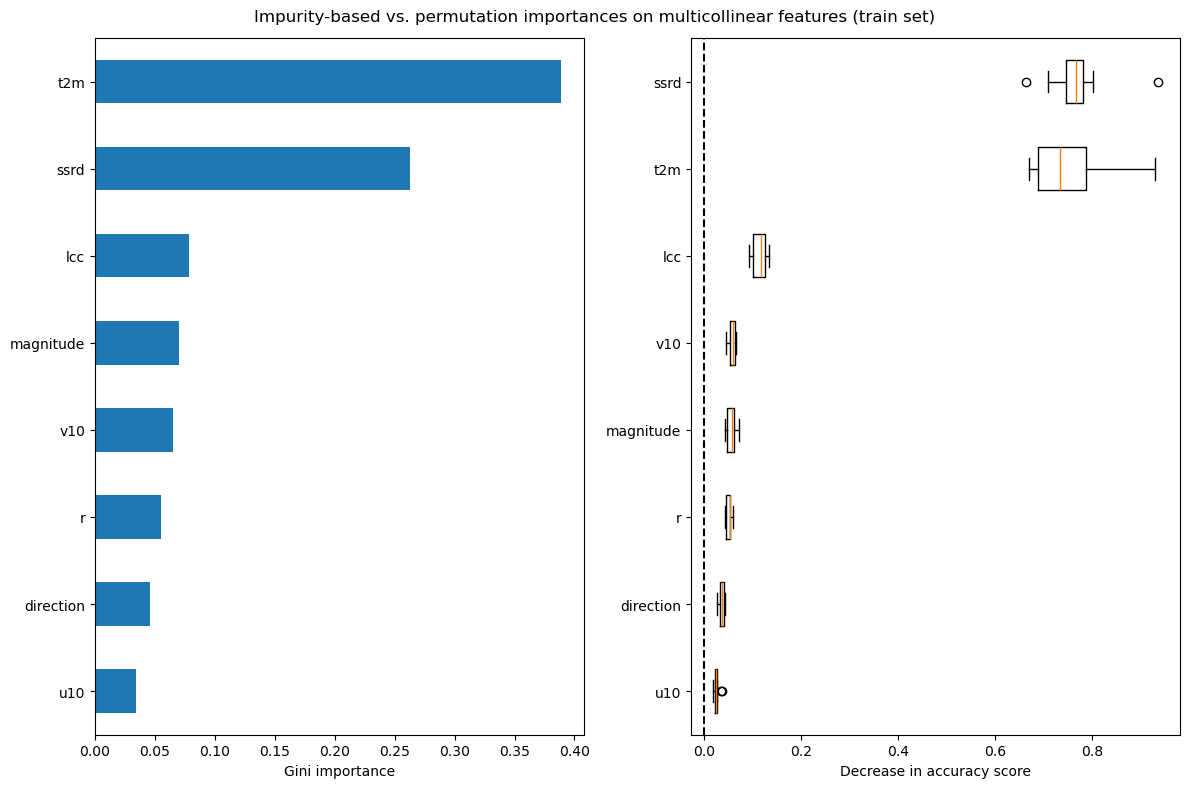

In [87]:
# permutation feature importance for random forest

mdi_importances = pd.Series(tree_model.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(tree_model.feature_importances_)
tree_indices = np.arange(0, len(tree_model.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(tree_model, X_train, y_train, ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances on multicollinear features (train set)"
)
_ = fig.tight_layout()



In [ ]:
#poly regression

from sklearn.preprocessing import PolynomialFeatures 
degree = 2 
polynomial_features = PolynomialFeatures(degree = degree)

x_train_poly = polynomial_features.fit_transform(X_train)
x_test_poly = polynomial_features.fit_transform(X_test) 
print(x_train_poly)

In [ ]:
pmodel = linear_model.LinearRegression() 
pmodel.fit(x_train_poly, y_train) 
y_poly_pred = model.predict(x_train_poly) 

#---plot the points--
plt.scatter(X_train, y_train, s=10) 
#---plot the regression line--
plt.plot(X_train, y_poly_pred) 
plt.show()